In [ ]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, f1_score
from torchvision import datasets, transforms #this is from pytorch
# we could do the same thing with tensorflow and keras



from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, confusion_matrix

import seaborn as sns
import os

# For reproducibility
np.random.seed(42)

learning_rates = [ 0.001]
batch_size = 64
epochs = 15


In [45]:
transform = transforms.ToTensor()

# Load the training dataset
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)

# Load the testing dataset
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)


with open('b2.pkl', 'rb') as b2:
  test_dataset = pickle.load(b2)



In [62]:
# Convert the datasets to numpy arrays for further processing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
def convert_to_numpy(dataset):
    X = []
    y = []
    for img, label in dataset:
        X.append(img.numpy().flatten())  # Flatten the 28x28 image to a 1D array of 784 elements
        y.append(label)
    return np.array(X), np.array(y)

# Convert train and test datasets to numpy arrays
X_train, y_train = convert_to_numpy(train_dataset)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

X_test, y_test = convert_to_numpy(test_dataset)

# scaler = StandardScaler()
scaler = MinMaxScaler()
X_test = scaler.fit_transform(X_test)
X_test = scaler.fit_transform(X_test)

print(f'Train Data Shape: {X_train.shape}, Train Labels Shape: {y_train.shape}')
print(f'Train Data Shape: {X_val.shape}, Train Labels Shape: {y_val.shape}')
print(f'Test Data Shape: {X_test.shape}, Test Labels Shape: {y_test.shape}')
print(y_test[:10])



Train Data Shape: (48000, 784), Train Labels Shape: (48000,)
Train Data Shape: (12000, 784), Train Labels Shape: (12000,)
Test Data Shape: (3611, 784), Test Labels Shape: (3611,)
[5 1 8 0 8 8 8 8 8 0]


In [47]:
class Dense:
    def __init__(self, input_size, output_size,lr=0.005, beta1=0.9, beta2=0.999, epsilon=1e-8):
        # self.weights = np.random.randn(input_size, output_size) * 0.01
        #Xavier initialization
        self.weights = np.random.randn(input_size, output_size) * np.sqrt(2.0 / input_size)

        self.bias = np.zeros((1, output_size))
        # print("dimenstions of weights and bias")
        # print(self.weights.shape)
        # print(self.bias.shape)
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon

        self.m_w, self.v_w = np.zeros_like(self.weights), np.zeros_like(self.weights)
        self.m_b, self.v_b = np.zeros_like(self.bias), np.zeros_like(self.bias)
        self.t = 0  # Time step


    #this part is common for all type of activation functions
    def forward(self, X):
        self.input = X
        return np.dot(X, self.weights) + self.bias #broadcasting
    
    def backward(self, d_output):
        # print("dense backward input shape") 
        # print(d_output.shape)
        prev_weights = self.weights
        d_weights = np.dot(self.input.T, d_output)
        d_bias = np.sum(d_output, axis=0, keepdims=True)

        # Update Adam time step
        self.t += 1

        # Moving averages of gradients for weights
        self.m_w = self.beta1 * self.m_w + (1 - self.beta1) * d_weights
        self.v_w = self.beta2 * self.v_w + (1 - self.beta2) * (d_weights ** 2)

        # Moving averages of gradients for biases
        self.m_b = self.beta1 * self.m_b + (1 - self.beta1) * d_bias
        self.v_b = self.beta2 * self.v_b + (1 - self.beta2) * (d_bias ** 2)

        # Bias correction
        m_w_hat = self.m_w / (1 - self.beta1 ** self.t)
        v_w_hat = self.v_w / (1 - self.beta2 ** self.t)
        m_b_hat = self.m_b / (1 - self.beta1 ** self.t)
        v_b_hat = self.v_b / (1 - self.beta2 ** self.t)

        # self.weights -= self.lr * d_weights
        # self.bias -= self.lr * d_bias
        # Parameter update
        self.weights -= self.lr * m_w_hat / (np.sqrt(v_w_hat) + self.epsilon)
        self.bias -= self.lr * m_b_hat / (np.sqrt(v_b_hat) + self.epsilon)

        # for preveious layers 
        return np.dot(d_output, prev_weights.T)
    

class ReLU:
    def forward(self, X):
        self.input = X
        return np.maximum(0, X)
    
    def backward(self, d_output):
        # print("relu backward input shape")
        # print(d_output.shape)
        return d_output * (self.input > 0)
    
class Dropout:
    def __init__(self, rate=0.2):
        # Rate is the fraction of units to drop (e.g., 0.2 means 20% will be dropped)
        self.rate = rate

    def forward(self, X, training=True):
        if training:
            # Create a dropout mask based on the dropout rate
            self.mask = (np.random.rand(*X.shape) > self.rate) / (1 - self.rate)
            return X * self.mask
        else:
            # During testing, dropout is not applied
            return X

    def backward(self, d_output):
        # Only backward the gradients where mask is non-zero
        return d_output * self.mask

    


In [48]:
class BatchNorm:
    def __init__(self, input_dim, lr=0.005,epsilon=1e-5, momentum=0.9):
        self.lr = lr    
        self.epsilon = epsilon
        self.momentum = momentum
        self.gamma = np.ones((1, input_dim))
        self.beta = np.zeros((1, input_dim))
        
        # Initialize moving averages for mean and variance
        self.running_mean = np.zeros((1, input_dim))
        self.running_var = np.ones((1, input_dim))

    def forward(self, X, training=True):
        if training:
            batch_mean = np.mean(X, axis=0, keepdims=True)
            batch_var = np.var(X, axis=0, keepdims=True)
            
            self.X_centered = X - batch_mean
            self.stddev_inv = 1. / np.sqrt(batch_var + self.epsilon)
            X_norm = self.X_centered * self.stddev_inv
            
            out = self.gamma * X_norm + self.beta # to give the model to flexibility to cancel out normalization if it is not needed
            
            self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * batch_mean
            self.running_var = self.momentum * self.running_var + (1 - self.momentum) * batch_var
        else:
            X_norm = (X - self.running_mean) / np.sqrt(self.running_var + self.epsilon)
            out = self.gamma * X_norm + self.beta
            
        return out

    def backward(self, d_output):
        n_samples = d_output.shape[0]
        
        d_gamma = np.sum(d_output * self.X_centered * self.stddev_inv, axis=0, keepdims=True)
        d_beta = np.sum(d_output, axis=0, keepdims=True)
        
        d_X_norm = d_output * self.gamma
   
        d_var = np.sum(d_X_norm * self.X_centered * -0.5 * self.stddev_inv**3, axis=0)
        d_mean = np.sum(d_X_norm * -self.stddev_inv, axis=0) + d_var * np.mean(-2. * self.X_centered, axis=0)
        
        d_input = d_X_norm * self.stddev_inv + d_var * 2 * self.X_centered / n_samples + d_mean / n_samples
 
        self.gamma -= self.lr * d_gamma
        self.beta -= self.lr * d_beta
        
        return d_input


In [49]:
class Softmax:
    def forward(self, x):
        x_max = np.max(x, axis=1, keepdims=True)
        exp_values = np.exp(x - x_max)
        
        sum_exp_values = np.sum(exp_values, axis=1, keepdims=True)
        epsilon = 1e-10
        probabilities = exp_values / (sum_exp_values + epsilon)
        return probabilities

    def backward(self, output, y):
        n_samples = y.shape[0]
        grad = output.copy()
        grad[range(n_samples), y] -= 1
        grad = grad / n_samples
        return grad

In [50]:
def cross_entropy_loss(predictions, labels):
    n_samples = labels.shape[0]
    # predictions = np.clip(predictions, 1e-15, 1 - 1e-15)
    logp = -np.log(predictions[range(n_samples), labels]+1e-15)
    # print("logp")
    # print(logp.shape)
    loss = np.sum(logp) / n_samples
    return loss

In [51]:
# hidden_layer1 = Dense(input_size=784, output_size=128)
# activation1 = ReLU()
# output1 = activation1.forward(hidden_layer1.forward(X_train))
# print("first layer output shape")
# print(output1.shape)
# hidden_layer2 = Dense(input_size=128, output_size=64)
# activation2 = ReLU()
# output2 = activation2.forward(hidden_layer2.forward(output1))
# print("second layer output shape")
# print(output2.shape)
# final_layer = Dense(input_size=64, output_size=10)
# activation3 = Softmax()
# output3 = activation3.forward(final_layer.forward(output2))#this is my y_prediction
# print("final layer output shape")
# print(output3.shape)


# print("y_train")
# print(y_train.shape)
# loss = cross_entropy_loss(output3, y_train)
# print(loss)

# d_activation3 = activation3.backward(output3, y_train)
# d_out3=final_layer.backward(d_activation3, 0.01)
# d_activation2 = activation2.backward(d_out3)
# d_out2=hidden_layer2.backward(d_activation2, 0.01)
# d_activation1 = activation1.backward(d_out2)
# d_out1=hidden_layer1.backward(d_activation1, 0.01)
# #




In [52]:
def save_model_weights(model, filename="model_1905099.pkl"):
    weights = {}
    for i, layer in enumerate(model.layers):
        if isinstance(layer, Dense):
            weights[f"layer_{i}_weights"] = layer.weights
            weights[f"layer_{i}_bias"] = layer.bias
        elif isinstance(layer, BatchNorm):
            weights[f"layer_{i}_gamma"] = layer.gamma
            weights[f"layer_{i}_beta"] = layer.beta
            weights[f"layer_{i}_running_mean"] = layer.running_mean
            weights[f"layer_{i}_running_var"] = layer.running_var
    # Save weights dictionary to a pickle file
    with open(filename, "wb") as f:
        pickle.dump(weights, f)
    print(f"Model weights and batch normalization parameters saved to {filename}")


def load_model_weights(model, filename="model_1905099.pkl"):
    # Load weights from pickle file
    with open(filename, "rb") as f:
        weights = pickle.load(f)
    
    for i, layer in enumerate(model.layers):
        if isinstance(layer, Dense):
            layer.weights = weights[f"layer_{i}_weights"]
            layer.bias = weights[f"layer_{i}_bias"]
        elif isinstance(layer, BatchNorm):
            layer.gamma = weights[f"layer_{i}_gamma"]
            layer.beta = weights[f"layer_{i}_beta"]
            layer.running_mean = weights[f"layer_{i}_running_mean"]
            layer.running_var = weights[f"layer_{i}_running_var"]
    print("Model weights and batch normalization parameters loaded successfully")


In [53]:
def adjust_learning_rate(model, epoch, initial_lr=0.005, decay_rate=0.9):
    lr = initial_lr * (decay_rate ** epoch)
    for layer in model.layers:
        if hasattr(layer, 'lr'):
            layer.lr = lr

In [54]:
class NeuralNetwork:
    def __init__(self, input_dim, num_classes,lr=0.001):
        self.softmax = Softmax()
        self.layers = [
            Dense(input_dim, 128),
            BatchNorm(128),
            ReLU(),
            Dropout(),
            Dense(128, 64),
            BatchNorm(64),
            ReLU(),
            Dropout(),
            Dense(64, num_classes)
        ]
        # Initialize lists to store metrics
        self.training_loss = []
        self.val_loss = []
        self.training_acc = []
        self.val_acc = []
        self.val_f1 = []


    def forward(self, X,training=True):
        for layer in self.layers:
            if isinstance(layer,(BatchNorm, Dropout)):
                X = layer.forward(X, training=training)
            else:
                X = layer.forward(X)

        return self.softmax.forward(X)
    
    def backward(self, d_output):
        for layer in reversed(self.layers):
            d_output = layer.backward(d_output)
        

    def train(self, X_train,y_train, X_val, y_val, epochs,batch_size):
        n_samples = X_train.shape[0]
        # training_loss, val_loss, training_acc, val_acc, val_f1 = [], [], [], [], []

        for epoch in range(epochs):
            losses = []
            for i in tqdm(range(0, n_samples, batch_size)):
                x_batch = X_train[i:i+batch_size]
                y_batch = y_train[i:i+batch_size]
                output = self.forward(x_batch)
                loss = cross_entropy_loss(output, y_batch)
                losses.append(loss)
                # print(f'Loss: {loss}')
                d_output = self.softmax.backward(output, y_batch)
                self.backward(d_output)

            # Training Loss & Accuracy
            train_preds = self.predict(X_train)
            train_accuracy = accuracy_score(y_train, train_preds)
            self.training_loss.append(np.mean(losses))
            self.training_acc.append(train_accuracy)

            # Validation Loss & Accuracy
            val_preds = self.predict(X_val)
            val_accuracy = accuracy_score(y_val, val_preds)
            val_f1_score = f1_score(y_val, val_preds, average="macro")
            val_loss_epoch = cross_entropy_loss(self.forward(X_val, training=False), y_val)

            self.val_loss.append(val_loss_epoch)
            self.val_acc.append(val_accuracy)
            self.val_f1.append(val_f1_score)

            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {self.training_loss[-1]:.4f}, "
                  f"Val Loss: {self.val_loss[-1]:.4f}, Train Acc: {train_accuracy:.4f}, "
                  f"Val Acc: {val_accuracy:.4f}, Val F1: {val_f1_score:.4f}")

        return self.training_loss, self.val_loss, self.training_acc, self.val_acc, self.val_f1

            
                    
    def predict(self,x_test):
        output = self.forward(x_test, training=False)
        predictions = np.argmax(output, axis=1)
        return predictions
    

best_model = None
best_f1_score =0

# Run experiments
results = {}
for lr in learning_rates:
    print(f"Training with learning rate: {lr}")
    model = NeuralNetwork(784, 10, lr)
    train_loss, val_loss, train_acc, val_acc, val_f1 = model.train(
        X_train, y_train, X_val, y_val, epochs, batch_size
    )
    results[lr] = (train_loss, val_loss, train_acc, val_acc, val_f1)
    if val_f1[-1] > best_f1_score:
        best_f1_score = val_f1[-1]
        print(f"Best model found with learning rate: {lr} and f1 score: {best_f1_score}")
        best_model = model


# make predictions
Y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, Y_pred)
precision = precision_score(y_test, Y_pred, average="weighted")
recall = recall_score(y_test, Y_pred, average="weighted")
f1 = f1_score(y_test, Y_pred, average="weighted")

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}, Recall: {recall}, F1 Score: {f1}")

# Save the model

# Confusion Matrix for best model
# best_lr = max(results, key=lambda lr: max(results[lr][4]))  # Highest val_f1
save_model_weights(best_model,"model_1_1905099.pkl")
       

Training with learning rate: 0.001


  0%|          | 0/750 [00:00<?, ?it/s]

100%|██████████| 750/750 [00:06<00:00, 110.26it/s]


Epoch 1/15, Train Loss: 0.5444, Val Loss: 0.4073, Train Acc: 0.8583, Val Acc: 0.8498, Val F1: 0.8479


100%|██████████| 750/750 [00:09<00:00, 81.89it/s] 


Epoch 2/15, Train Loss: 0.4260, Val Loss: 0.3926, Train Acc: 0.8672, Val Acc: 0.8571, Val F1: 0.8564


100%|██████████| 750/750 [00:07<00:00, 95.67it/s] 


Epoch 3/15, Train Loss: 0.3879, Val Loss: 0.3591, Train Acc: 0.8830, Val Acc: 0.8669, Val F1: 0.8670


100%|██████████| 750/750 [00:10<00:00, 69.82it/s] 


Epoch 4/15, Train Loss: 0.3646, Val Loss: 0.3523, Train Acc: 0.8878, Val Acc: 0.8718, Val F1: 0.8724


100%|██████████| 750/750 [00:08<00:00, 84.36it/s] 


Epoch 5/15, Train Loss: 0.3498, Val Loss: 0.3402, Train Acc: 0.8948, Val Acc: 0.8739, Val F1: 0.8732


100%|██████████| 750/750 [00:06<00:00, 115.21it/s]


Epoch 6/15, Train Loss: 0.3380, Val Loss: 0.3310, Train Acc: 0.9007, Val Acc: 0.8811, Val F1: 0.8810


100%|██████████| 750/750 [00:06<00:00, 121.87it/s]


Epoch 7/15, Train Loss: 0.3259, Val Loss: 0.3388, Train Acc: 0.9015, Val Acc: 0.8793, Val F1: 0.8793


100%|██████████| 750/750 [00:06<00:00, 107.42it/s]


Epoch 8/15, Train Loss: 0.3187, Val Loss: 0.3306, Train Acc: 0.9044, Val Acc: 0.8814, Val F1: 0.8813


100%|██████████| 750/750 [00:08<00:00, 92.43it/s] 


Epoch 9/15, Train Loss: 0.3077, Val Loss: 0.3339, Train Acc: 0.9067, Val Acc: 0.8817, Val F1: 0.8808


100%|██████████| 750/750 [00:07<00:00, 100.29it/s]


Epoch 10/15, Train Loss: 0.3011, Val Loss: 0.3289, Train Acc: 0.9100, Val Acc: 0.8823, Val F1: 0.8820


100%|██████████| 750/750 [00:05<00:00, 129.54it/s]


Epoch 11/15, Train Loss: 0.2905, Val Loss: 0.3129, Train Acc: 0.9150, Val Acc: 0.8892, Val F1: 0.8890


100%|██████████| 750/750 [00:06<00:00, 115.07it/s]


Epoch 12/15, Train Loss: 0.2867, Val Loss: 0.3229, Train Acc: 0.9165, Val Acc: 0.8872, Val F1: 0.8866


100%|██████████| 750/750 [00:06<00:00, 121.70it/s]


Epoch 13/15, Train Loss: 0.2804, Val Loss: 0.3318, Train Acc: 0.9126, Val Acc: 0.8842, Val F1: 0.8837


100%|██████████| 750/750 [00:06<00:00, 121.15it/s]


Epoch 14/15, Train Loss: 0.2728, Val Loss: 0.3298, Train Acc: 0.9177, Val Acc: 0.8865, Val F1: 0.8859


100%|██████████| 750/750 [00:05<00:00, 134.38it/s]


Epoch 15/15, Train Loss: 0.2700, Val Loss: 0.3244, Train Acc: 0.9205, Val Acc: 0.8875, Val F1: 0.8871
Best model found with learning rate: 0.001 and f1 score: 0.8871053482924879
Accuracy: 0.23899196898366104
Precision: 0.3746522157359998, Recall: 0.23899196898366104, F1 Score: 0.09659907662241651
Model weights and batch normalization parameters saved to model_1_1905099.pkl


d:\New folder\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\New folder\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [55]:
# test_model = NeuralNetwork(784, 10)

# load_model_weights(test_model, "best_model.pkl")
# print("test model lr")
# print(test_model.layers[0].lr)
# y_pred = test_model.predict(X_test)

# # Generate Confusion Matrix
# conf_matrix = confusion_matrix(y_test, y_pred)
# plt.figure(figsize=(10, 8))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
# plt.title("Confusion Matrix")
# plt.xlabel("Predicted")
# plt.ylabel("Actual")
# plt.show()


Model weights and batch normalization parameters loaded successfully
Accuracy: 0.7435613403489338
Precision: 0.8678002369194779, Recall: 0.7435613403489338, F1 Score: 0.7584439214761259


d:\New folder\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


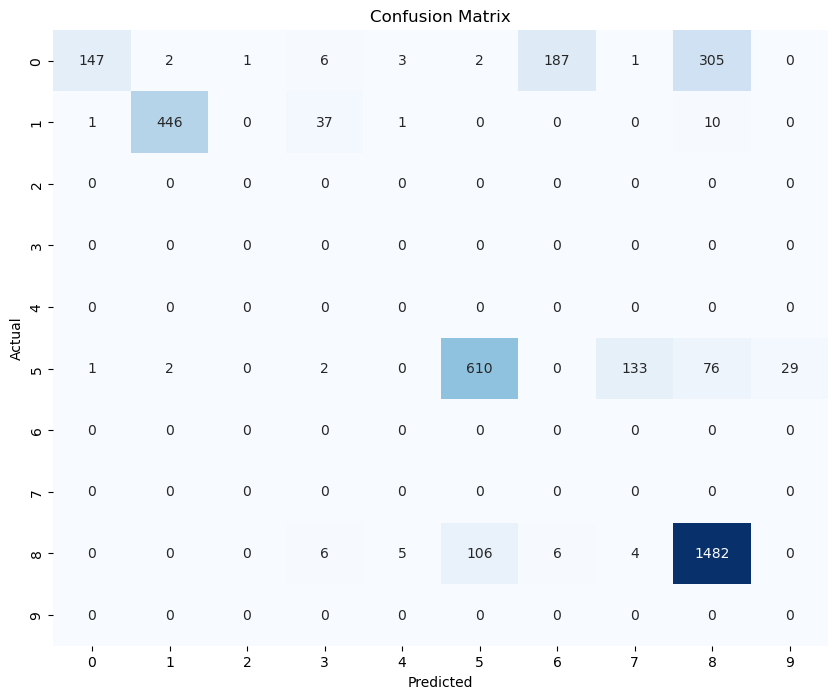

In [63]:

new_model = NeuralNetwork(784,10)

load_model_weights(new_model,"model_1_1905099.pkl")


# make predictions
Y_pred = new_model.predict(X_test)
accuracy = accuracy_score(y_test, Y_pred)
precision = precision_score(y_test, Y_pred, average="weighted")
recall = recall_score(y_test, Y_pred, average="weighted")
f1 = f1_score(y_test, Y_pred, average="weighted")

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}, Recall: {recall}, F1 Score: {f1}")

conf_matrix = confusion_matrix(y_test, Y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Learning Rate: 0.001
Training Loss: [0.5444290643417365, 0.42602171108014864, 0.387904679381628, 0.36455520743873027, 0.34977565932677757, 0.33795246825093267, 0.3259477867945421, 0.3187324981320813, 0.3076641358833466, 0.3010920441999246, 0.29051920941980747, 0.2867172629385809, 0.2804093102661667, 0.27283561271912654, 0.2700344498805833]
Validation Loss: [0.4072854147020562, 0.39261488883298734, 0.3591237639531606, 0.3523323233103652, 0.3402161721514616, 0.3309961280722395, 0.3388198694862123, 0.33064913996063605, 0.33385915356673274, 0.3288700087209309, 0.31289494674788176, 0.32287321883394826, 0.33176220285702124, 0.3298249104676261, 0.32442021905199675]
Training Accuracy: [0.8582916666666667, 0.8671666666666666, 0.8830416666666666, 0.8877916666666666, 0.89475, 0.9007083333333333, 0.9015208333333333, 0.9043958333333333, 0.9067291666666667, 0.9099583333333333, 0.9149583333333333, 0.9164791666666666, 0.9125833333333333, 0.9177291666666667, 0.9205]
Validation Accuracy: [0.84975, 0.857

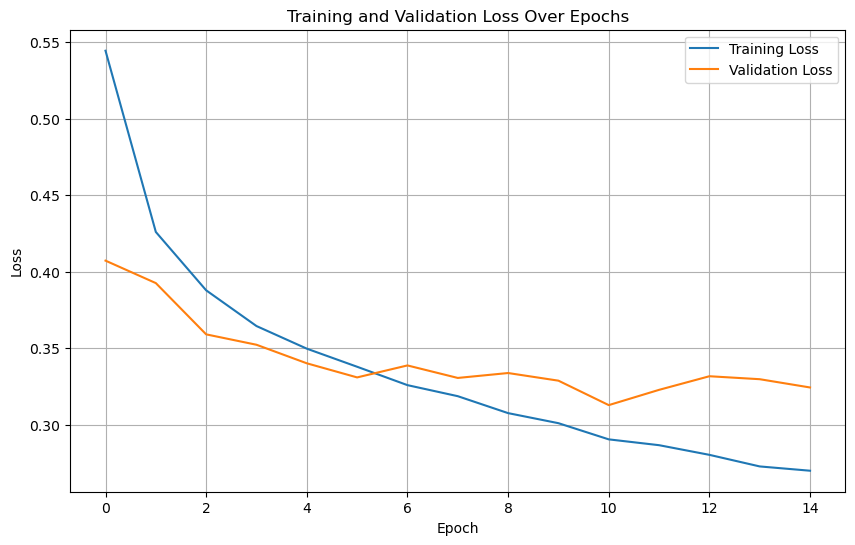

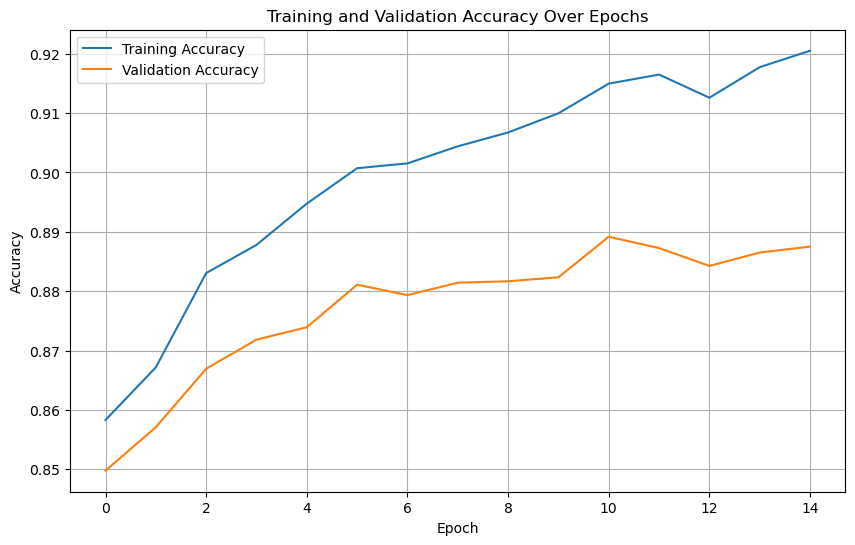

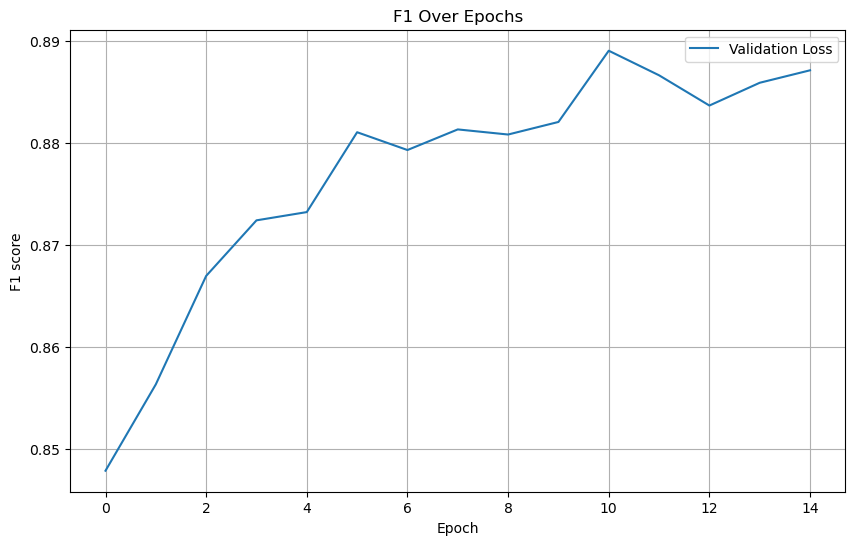

In [57]:

for lr, metrics in results.items():
    train_loss, val_loss, train_acc, val_acc, val_f1 = metrics
    print(f"Learning Rate: {lr}")
    print(f"Training Loss: {train_loss}")
    print(f"Validation Loss: {val_loss}")
    print(f"Training Accuracy: {train_acc}")
    print(f"Validation Accuracy: {val_acc}")
    print(f"Validation F1 Score: {val_f1}")
    print("-" * 30)
    
    # Plot Training and Validation Loss
    plt.figure(figsize=(10, 6))
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(val_f1, label='Validation Loss')
    plt.title('F1 Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('F1 score')
    plt.legend()
    plt.grid(True)
    plt.show()


